<a href="https://colab.research.google.com/github/prawizard/SentimentAnalysis/blob/main/SentimentAnalysis_AmazonReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load all libraries as required
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import numpy as np
import random
import pandas as pd
import os
import io, json
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import files

In [ ]:
# Install Kaggle API
! pip install -q kaggle

In [ ]:
# 

# Define constants used in the code
oov_tok = "<OOV>"
embedding_dim = 16
padding_type='post'
vocab_size = 10000
trunc_type='post'
max_length = 100

In [ ]:
# 

files.upload()

In [ ]:
# 


! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d kritanjalijain/amazon-reviews

 99% 1.29G/1.29G [00:22<00:00, 108MB/s] 
100% 1.29G/1.29G [00:22<00:00, 61.0MB/s]


In [ ]:
# 


# Extrract the contents from zip file
data_path='/content/amazon-reviews'
refer_zip   = zipfile.ZipFile('/content/amazon-reviews.zip', 'r')
refer_zip.extractall(data_path)
refer_zip.close()

In [ ]:
# 

!rm amazon-reviews.zip
!rm kaggle.json
! cp amazon-reviews/train.csv /content/
! cp amazon-reviews/test.csv /content/
%rm -rf amazon-reviews

In [ ]:
# 


# read the csv file
dataset=pd.read_csv('train.csv', header=None)

In [ ]:
# 

# 2: positive review
# 1: negative review
dataset.tail()

,0,1,2
3599995,1,Don't do it!!,The high chair looks great when it first comes...
3599996,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
3599997,1,"compact, but hard to clean","We have a small house, and really wanted two o..."
3599998,1,what is it saying?,not sure what this book is supposed to be. It ...
3599999,2,Makes My Blood Run Red-White-And-Blue,I agree that every American should read this b...


In [ ]:
# 

x=dataset[2]
y=dataset[0]

In [ ]:
# 

x.head()

0    This sound track was beautiful! It paints the ...
1    I'm reading a lot of reviews saying that this ...
2    This soundtrack is my favorite music of all ti...
3    I truly like this soundtrack and I enjoy video...
4    If you've played the game, you know how divine...
Name: 2, dtype: object

In [ ]:
# 

len(y)

3600000

In [ ]:
# 

dataset_size=int(3600000/1)
# 75% of the data for training and 25% for testing
train_proportion=0.75

In [ ]:
# 

x_data=list(x)
y_data=list(y)

# x=x[0:dataset_size]  # 0 to 1200000
# y=y[0:dataset_size]

x_training=x_data[0:int(train_proportion*dataset_size)] # 75% for training
x_test=x_data[int(train_proportion*dataset_size):dataset_size] # 25% for testing

y_training=y_data[0:int(train_proportion*dataset_size)]
y_test=y_data[int(train_proportion*dataset_size):dataset_size]

In [ ]:
# 

len(x_training+x_test)

3600000

In [ ]:
# 

len(x_training)/len(x_training+x_test)

0.75

In [ ]:
# 

x_training[0:5]

['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all th

In [ ]:
# To fit a new tokenizer

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(x_training) # Tokenize the sentences in x_training.

In [ ]:
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# # 

# # To load the saved tokenizer


# with open('tokenizer.json') as f:
#     data = json.load(f)
#     loaded_tokenizer = tokenizer_from_json(data)
# tokenizer=loaded_tokenizer

In [ ]:
# 

word_index = tokenizer.word_index # dictionary with words mapped to word ids

training_sequences = tokenizer.texts_to_sequences(x_training) # represent words using word ids in each sentence 
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # make all sequences have same length by padding

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# 

([int(i>1) for i in y_training[0:10]])

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]

In [ ]:
# 

import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array([i>1 for i in y_training])*1
testing_padded = np.array(testing_padded)
testing_labels = np.array([ i>1 for i in y_test])*1

# convert to numpy array as the model expects input in numpy format

In [ ]:
# define model with layers. Using dropout layer to prevent overfitting. Using embedding layer to improve the performance

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(50),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 50)                13400     
                                                                 
 dense_4 (Dense)             (None, 128)               6528      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [ ]:
num_epochs = 10
# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), batch_size=256, verbose=2)

Epoch 1/10
10547/10547 - 231s - loss: 0.2568 - accuracy: 0.8935 - val_loss: 0.2205 - val_accuracy: 0.9153 - 231s/epoch - 22ms/step
Epoch 2/10
10547/10547 - 222s - loss: 0.2051 - accuracy: 0.9195 - val_loss: 0.2090 - val_accuracy: 0.9198 - 222s/epoch - 21ms/step
Epoch 3/10
10547/10547 - 222s - loss: 0.1892 - accuracy: 0.9262 - val_loss: 0.1935 - val_accuracy: 0.9263 - 222s/epoch - 21ms/step
Epoch 4/10
10547/10547 - 220s - loss: 0.1786 - accuracy: 0.9310 - val_loss: 0.1960 - val_accuracy: 0.9278 - 220s/epoch - 21ms/step
Epoch 5/10
10547/10547 - 221s - loss: 0.1707 - accuracy: 0.9343 - val_loss: 0.1860 - val_accuracy: 0.9286 - 221s/epoch - 21ms/step
Epoch 6/10
10547/10547 - 223s - loss: 0.1647 - accuracy: 0.9370 - val_loss: 0.1818 - val_accuracy: 0.9295 - 223s/epoch - 21ms/step
Epoch 7/10
10547/10547 - 222s - loss: 0.1597 - accuracy: 0.9393 - val_loss: 0.1815 - val_accuracy: 0.9304 - 222s/epoch - 21ms/step
Epoch 8/10
10547/10547 - 222s - loss: 0.1559 - accuracy: 0.9408 - val_loss: 0.1825 

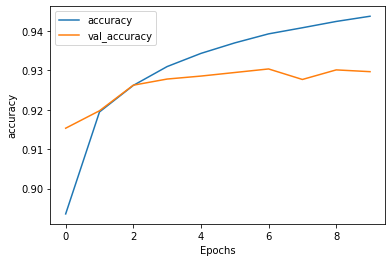

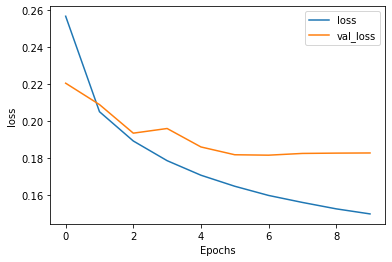

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# evaluate on test set

model.evaluate(testing_padded, testing_labels)

28125/28125 [==============================] - 264s 9ms/step - loss: 0.1827 - accuracy: 0.9297


[0.1827353835105896, 0.9296833276748657]

In [ ]:
len(x_training)

2700000

In [ ]:
y_pred=(model.predict(testing_padded) >= 0.5)*1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
# f1-score for the classification performance
f1_score(testing_labels, y_pred)

0.8913619396163448

In [ ]:
# accuracy-score for the classification performance

accuracy_score(testing_labels, y_pred)

0.8910566666666667

In [ ]:
dataset[2][3599990]

'Tyler Hilton....a name you might not know now, but for SURE will within the upcoming months! With his upcoming CD "The Tracks Of...," Tyler\'s storming the music scene. He showcases some of these songs on his self-titled EP. From the bouncy, singalong "When it comes," reminiscent of summer evening drives and nights at the local diner with friends, he takes us into a universal breakup story in "Pink and Black." "Letter Song\' and "Slide" are both singable tunes, but simultaneously give way to showcase Tyler\'s extremely proficient guitar skills. This is a must-own!'

In [ ]:
# test on any random single review

sentence = [dataset[2][3599990]]
print(sentence)
print('-------------------------------------------')
print('-------------------------------------------')
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

result=model.predict(padded)
print(result)

['Tyler Hilton....a name you might not know now, but for SURE will within the upcoming months! With his upcoming CD "The Tracks Of...," Tyler\'s storming the music scene. He showcases some of these songs on his self-titled EP. From the bouncy, singalong "When it comes," reminiscent of summer evening drives and nights at the local diner with friends, he takes us into a universal breakup story in "Pink and Black." "Letter Song\' and "Slide" are both singable tunes, but simultaneously give way to showcase Tyler\'s extremely proficient guitar skills. This is a must-own!']
-------------------------------------------
-------------------------------------------
[[0.95333487]]


In [ ]:
result

array([[0.95333487]], dtype=float32)

In [ ]:
dataset.index[dataset[0]==2]

Int64Index([      0,       1,       2,       3,       4,       5,       7,
                  8,       9,      11,
            ...
            3599982, 3599984, 3599985, 3599986, 3599988, 3599989, 3599990,
            3599991, 3599992, 3599999],
           dtype='int64', length=1800000)

In [ ]:
# 

# read the dataset unused during training

unused_data=pd.read_csv('test.csv', header=None)

In [ ]:
# 

unused_data.head()

,0,1,2
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [ ]:
# 

X_unseen=unused_data[2]
y_unseen=unused_data[0]

In [ ]:
dataset[0].value_counts()

2    1800000
1    1800000
Name: 0, dtype: int64

<function matplotlib.pyplot.show>

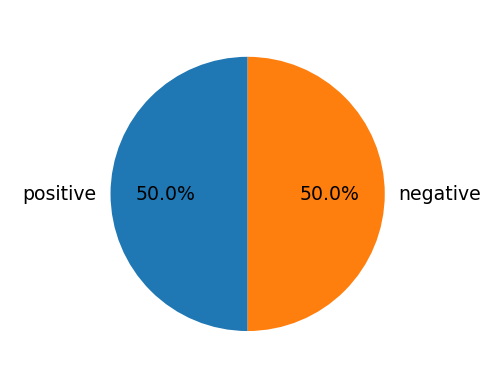

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

positive_count=dataset[0].value_counts()[2]
negative_count=dataset[0].value_counts()[1]

categoryNames=['positive', 'negative']
sizes=[positive_count, negative_count]
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=categoryNames, textprops={'fontsize':6}, startangle=90, autopct='%1.1f%%')
plt.show

In [ ]:
# 

X_unseen[:2]

0    My lovely Pat has one of the GREAT voices of h...
1    Despite the fact that I have only played a sma...
Name: 2, dtype: object

In [ ]:
# 

Unseen_sequences = tokenizer.texts_to_sequences(X_unseen) # represent words using word ids in each sentence 
Unseen_padded = pad_sequences(Unseen_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# 

Unseen_padded = np.array(Unseen_padded)
y_unseen = np.array([i>1 for i in y_unseen])*1

In [ ]:
# 

len(y_unseen)

400000

In [ ]:
model.evaluate(Unseen_padded, y_unseen)

12500/12500 [==============================] - 117s 9ms/step - loss: 0.1856 - accuracy: 0.9281


[0.1855805516242981, 0.9280675053596497]

In [ ]:
unused_data.index[unused_data[0]==1]

Int64Index([     2,      5,      6,      7,      9,     11,     12,     14,
                15,     20,
            ...
            399984, 399988, 399989, 399991, 399992, 399993, 399995, 399996,
            399997, 399999],
           dtype='int64', length=200000)

In [ ]:
# test on a random review from previously unseen dataset

sentence = [unused_data[2][399992]]
print(sentence)
print('-------------------------------------------')
print('-------------------------------------------')
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

result=model.predict(padded)
print(result)

['This is not what I expected. I thought this was an all out rock band and to my dismay I found noise. I can actually sit down and listen to this though. Another review mentioned Merzbow...I think they hit the nail on the head. It has a hint of Meat Beat Manifesto also. I think some of Mike Pattons work also is along this same route.']
-------------------------------------------
-------------------------------------------
[[0.2617413]]


In [ ]:
model.save('saved_model.h5') 

In [ ]:
# 

# To execute using the loaded model



loaded_model=tf.keras.models.load_model('saved_model.h5')

In [ ]:
# 

loaded_model.evaluate(testing_padded, testing_labels)

28125/28125 [==============================] - 259s 9ms/step - loss: 0.1827 - accuracy: 0.9297


[0.1827353835105896, 0.9296833276748657]

In [ ]:
from sklearn.metrics import confusion_matrix


y_pred=(loaded_model.predict(testing_padded) >= 0.5)*1

confusion_matrix(testing_labels, y_pred)


array([[423385,  28758],
       [ 34527, 413330]])

In [ ]:
cm=np.array([[423385,  28758],
       [ 34527, 413330]])
cm=cm*100/np.sum(cm)

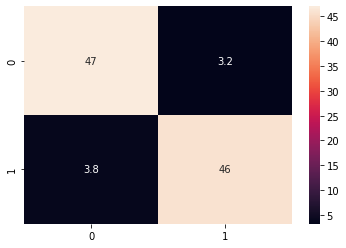

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [ ]:
# 

loaded_model.evaluate(Unseen_padded, y_unseen)

12500/12500 [==============================] - 26s 2ms/step - loss: 0.2605 - accuracy: 0.8912


[0.2605000138282776, 0.8911525011062622]

In [ ]:
testing_padded.shape

(900000, 100)

In [ ]:
Unseen_padded.shape

(400000, 100)

In [ ]:
len(unused_data)

400000

In [ ]:
len(dataset)

3600000

In [ ]:
training_padded.shape

(2700000, 100)

In [ ]:
training_labels.shape

(2700000,)

In [ ]:
testing_padded.shape

(900000, 100)

In [ ]:
testing_labels.shape

(900000,)

In [ ]:
type(tokenizer)

keras_preprocessing.text.Tokenizer

## Examples to try

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
from nltk.tokenize import word_tokenize

txt='We are processing text'

print(word_tokenize(txt))

['We', 'are', 'processing', 'text']


In [ ]:
exp_training=["Liked it. The product is worth the price.", 
              "Price is high. Expected it to be better", 
              "Better than expected",
              "I liked it"]

exp_tokenizer = Tokenizer(num_words=5, oov_token="<OOV>") 
exp_tokenizer.fit_on_texts(exp_training)

In [ ]:
exp_tokenizer.word_index

{'<OOV>': 1,
 'be': 13,
 'better': 8,
 'expected': 7,
 'high': 11,
 'i': 15,
 'is': 5,
 'it': 2,
 'liked': 3,
 'price': 6,
 'product': 9,
 'than': 14,
 'the': 4,
 'to': 12,
 'worth': 10}

In [ ]:
print(exp_tokenizer.texts_to_sequences(exp_training))

[[3, 2, 4, 1, 1, 1, 4, 1], [1, 1, 1, 1, 2, 1, 1, 1], [1, 1, 1], [1, 3, 2]]


In [ ]:
train_sequences=exp_tokenizer.texts_to_sequences(exp_training)

for seq in train_sequences:
  print(seq)

[3, 2, 4, 1, 1, 1, 4, 1]
[1, 1, 1, 1, 2, 1, 1, 1]
[1, 1, 1]
[1, 3, 2]
